In [ ]:
!pip install --user xgboost
import xgboost
import pandas as pd
from datetime import datetime
import numpy as np
import torch
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import TensorDataset, DataLoader
# !pip install --user fuzzywuzzy
# from fuzzywuzzy import fuzz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
df = pd.read_csv("train.csv", error_bad_lines=False, engine="python")                                                                                                                                    
df

cpu


<ipython-input-2-5f863eb7f671>:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv("train.csv", error_bad_lines=False, engine="python")
Skipping line 9331: unexpected end of data


,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."
...,...,...,...,...,...,...,...,...,...
9324,1372824454620000520,C,NaN,NaN,20000520,1372824454,A,False,"[[-8.649261,41.178492],[-8.651088,41.178132],[..."
9325,1372819621620000540,B,NaN,61.0,20000540,1372819621,A,False,"[[-8.59923,41.149152],[-8.598699,41.148666],[-..."
9326,1372825357620000307,C,NaN,NaN,20000307,1372825357,A,False,"[[-8.621523,41.147478],[-8.621514,41.14746],[-..."
9327,1372801521620000030,A,28984.0,NaN,20000030,1372801521,A,False,"[[-8.604243,41.180103],[-8.604198,41.180139],[..."


In [ ]:
def parse_time(x):
    dt = datetime.fromtimestamp(x["TIMESTAMP"])
    return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

df[["YR", "MON", "DAY", "HR", "WK"]] = df[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
df = df.drop(columns=['ORIGIN_CALL', 'DAY_TYPE','TRIP_ID']) 
df = df[df.get('MISSING_DATA') == False] 


def polyline_to_trip_duration(polyline):
    return max(polyline.count("[") - 1, 0) * 15

df["trip_time"] = df["POLYLINE"].apply(polyline_to_trip_duration)

In [ ]:
origin_df = pd.read_csv('metaData_taxistandsID_name_GPSlocation.csv')

def parse_stand(origin):
    origin = origin.values[0]
    if (int(origin)) < 0:
        return -1, -1, 'NA'
    area = ((origin_df.iloc[int(origin) - 1].values[1]))
    int1, int2 = (origin_df.iloc[int(origin) - 1].values[2:4])[0], (origin_df.iloc[int(origin) - 1].values[2:4])[1]
    if(int1 == '41.163066654-8.67598304213'):
        int1, int2 = '41.163066654', '-8.67598304213'
    lat, longi = float(int1), float(int2)
    return lat, longi, area


In [ ]:
df

,CALL_TYPE,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,YR,MON,DAY,HR,WK,trip_time
0,C,NaN,20000589,1372636858,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013,7,1,0,0,345
1,B,7.0,20000596,1372637303,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",2013,7,1,0,0,285
2,C,NaN,20000320,1372636951,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",2013,7,1,0,0,975
3,C,NaN,20000520,1372636854,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",2013,7,1,0,0,645
4,C,NaN,20000337,1372637091,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",2013,7,1,0,0,435
...,...,...,...,...,...,...,...,...,...,...,...,...
9324,C,NaN,20000520,1372824454,False,"[[-8.649261,41.178492],[-8.651088,41.178132],[...",2013,7,3,4,2,1320
9325,B,61.0,20000540,1372819621,False,"[[-8.59923,41.149152],[-8.598699,41.148666],[-...",2013,7,3,2,2,390
9326,C,NaN,20000307,1372825357,False,"[[-8.621523,41.147478],[-8.621514,41.14746],[-...",2013,7,3,4,2,540
9327,A,NaN,20000030,1372801521,False,"[[-8.604243,41.180103],[-8.604198,41.180139],[...",2013,7,2,21,1,735


In [ ]:
# get rid of NaN values and one-hot encode CALL_TYPE
df['ORIGIN_STAND'].fillna(-100, inplace=True)
df[["Latitude", "Longitude", "Area"]] = df[["ORIGIN_STAND"]].apply(parse_stand, axis=1, result_type="expand")
# perform one-hot encoding
one_hot = pd.get_dummies(df['CALL_TYPE'])

# concatenate the one-hot encoded dataframe with the original dataframe
df = pd.concat([df, one_hot], axis=1)
df['MISSING_DATA'] = 0
df

,CALL_TYPE,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,YR,MON,DAY,HR,WK,trip_time,Latitude,Longitude,Area,A,B,C
0,C,-100.0,20000589,1372636858,0,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013,7,1,0,0,345,-1.00000,-1.000000,NA,0,0,1
1,B,7.0,20000596,1372637303,0,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",2013,7,1,0,0,285,41.15998,-8.641984,Av. Boavista,0,1,0
2,C,-100.0,20000320,1372636951,0,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",2013,7,1,0,0,975,-1.00000,-1.000000,NA,0,0,1
3,C,-100.0,20000520,1372636854,0,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",2013,7,1,0,0,645,-1.00000,-1.000000,NA,0,0,1
4,C,-100.0,20000337,1372637091,0,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",2013,7,1,0,0,435,-1.00000,-1.000000,NA,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9324,C,-100.0,20000520,1372824454,0,"[[-8.649261,41.178492],[-8.651088,41.178132],[...",2013,7,3,4,2,1320,-1.00000,-1.000000,NA,0,0,1
9325,B,61.0,20000540,1372819621,0,"[[-8.59923,41.149152],[-8.598699,41.148666],[-...",2013,7,3,2,2,390,41.14931,-8.600309,Vinte e Quatro de Agosto,0,1,0
9326,C,-100.0,20000307,1372825357,0,"[[-8.621523,41.147478],[-8.621514,41.14746],[-...",2013,7,3,4,2,540,-1.00000,-1.000000,NA,0,0,1
9327,A,-100.0,20000030,1372801521,0,"[[-8.604243,41.180103],[-8.604198,41.180139],[...",2013,7,2,21,1,735,-1.00000,-1.000000,NA,1,0,0


In [ ]:
from pandas.core.groupby.generic import DataFrame
from sklearn.preprocessing import LabelEncoder
df = df.loc[df['POLYLINE'].apply(lambda x: max(x.count("[") - 1, 0) > 0)]
df['TAXI_ID'] = df['TAXI_ID'] - 20000000 
le = LabelEncoder()
le.fit(df['Area'])
df['Area_Nums'] = le.transform(df['Area'])
df

<ipython-input-7-0241b6463536>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TAXI_ID'] = df['TAXI_ID'] - 20000000
<ipython-input-7-0241b6463536>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Area_Nums'] = le.transform(df['Area'])


,CALL_TYPE,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,YR,MON,DAY,HR,WK,trip_time,Latitude,Longitude,Area,A,B,C,Area_Nums
0,C,-100.0,589,1372636858,0,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013,7,1,0,0,345,-1.00000,-1.000000,NA,0,0,1,39
1,B,7.0,596,1372637303,0,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",2013,7,1,0,0,285,41.15998,-8.641984,Av. Boavista,0,1,0,5
2,C,-100.0,320,1372636951,0,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",2013,7,1,0,0,975,-1.00000,-1.000000,NA,0,0,1,39
3,C,-100.0,520,1372636854,0,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",2013,7,1,0,0,645,-1.00000,-1.000000,NA,0,0,1,39
4,C,-100.0,337,1372637091,0,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",2013,7,1,0,0,435,-1.00000,-1.000000,NA,0,0,1,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9324,C,-100.0,520,1372824454,0,"[[-8.649261,41.178492],[-8.651088,41.178132],[...",2013,7,3,4,2,1320,-1.00000,-1.000000,NA,0,0,1,39
9325,B,61.0,540,1372819621,0,"[[-8.59923,41.149152],[-8.598699,41.148666],[-...",2013,7,3,2,2,390,41.14931,-8.600309,Vinte e Quatro de Agosto,0,1,0,60
9326,C,-100.0,307,1372825357,0,"[[-8.621523,41.147478],[-8.621514,41.14746],[-...",2013,7,3,4,2,540,-1.00000,-1.000000,NA,0,0,1,39
9327,A,-100.0,30,1372801521,0,"[[-8.604243,41.180103],[-8.604198,41.180139],[...",2013,7,2,21,1,735,-1.00000,-1.000000,NA,1,0,0,39


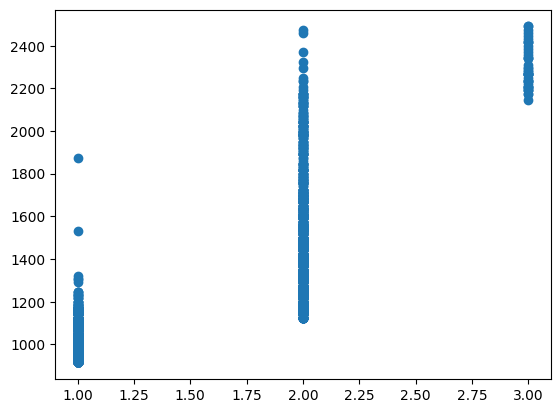

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

underDf = df[df.get("trip_time") <= 900]
overDf = df[(df.get("trip_time") > 900) & (df.get("trip_time") < 2500)]

y = overDf['trip_time']
y = y.sort_values()
import matplotlib.pyplot as plt
x = overDf['DAY']
plt.scatter(x.values, y.values)

currDf shape: 1706


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


{'validation_0': OrderedDict([('rmse', [186.4264269736063, 137.18135375254812, 110.7855062620247, 101.20394668509331, 96.24891037398017, 95.48494331526747, 94.31308636374975, 94.3421212131772, 94.62731788805308, 94.68830053433314, 95.8560123751877, 94.6820746218635, 94.80135679425183, 94.3705546724439, 94.74409820521207, 93.48341555052428, 93.28780569799015, 93.40459538653934, 94.12140360604725, 94.08015669556777, 94.54671221248157, 95.58793131011187, 94.98817631679417, 95.1602610363317, 94.0295297226701, 94.3897286535904, 94.29161415063778, 94.29381494052357, 94.10190717726876, 94.3768427213816, 94.71212404321949, 94.87436135540642, 94.45908389258739, 94.83188039127737, 94.82821685865409, 94.70351109084392, 94.41494707735427, 94.55322517194307, 94.47752813606222, 94.49875553521781, 94.45788886746833, 94.0342387419993, 94.55876726648128, 94.85064278732966, 94.65768171864337, 94.8062401521659, 94.92551641697173, 94.70836177434157, 94.9484710030919, 94.85727896113387, 94.04659404170074, 

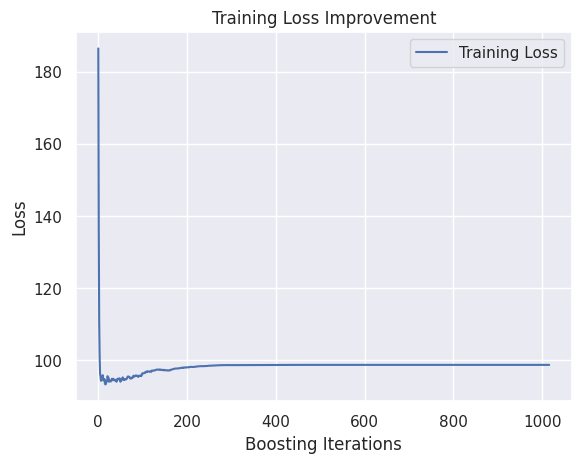

XGB Mean squared error for bin$(0, 360): 8702.61
3167    180
7385    210
9006    360
470     270
2653    345
       ... 
4427    345
5341    105
217     255
7884    165
3074    300
Name: trip_time, Length: 86, dtype: int64
[224.62254  239.48051  290.71008  184.816    266.66235  275.85446
 263.98898  288.34814  267.0888    54.777435 260.9801   307.02914
 208.0593   196.51126  310.00928  316.6982   279.11133  287.34125
 237.7556   290.8503   229.00607  292.32748  300.1562   178.3034
 255.32523  288.9935   160.13976  230.62772  294.4984   261.43488
 307.9475   280.07248  273.72775  275.12515  268.6087   267.08533
 290.5698   237.01047  309.92352  261.7565   274.76743  291.4291
 267.98706  272.71082  256.02597  254.08514  298.70743  226.66212
 280.0852   304.17337  314.59894  230.54785  266.66235  263.45914
 199.86217  263.8003   256.33752  293.86328  210.79256  299.9601
 304.81345  154.29643  275.7283   287.48593  292.09445   87.67163
 310.0937   145.16095  279.04025  259.89807  250.67389

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


{'validation_0': OrderedDict([('rmse', [404.7217068526146, 274.54663738903366, 207.03147112255243, 175.26020000095085, 160.2202072257846, 154.24168759224838, 152.2298888010033, 150.95384296006088, 149.79685402472907, 150.04894897784524, 150.54273903088236, 150.2845268148226, 150.59857981807693, 150.91482805564, 151.81054076037034, 152.82390803185865, 152.40536153952917, 151.94072304220614, 151.91159844625676, 152.42011653561667, 152.87152716845566, 152.54996372943052, 152.76747128213202, 153.1090794026762, 153.21857101133608, 153.31594879630356, 154.09543871225532, 154.25127157142828, 154.17837775832976, 154.63437309250318, 154.95579811693588, 155.0497988859455, 155.4650838927395, 156.01040705014015, 155.91452914234472, 155.92895128552715, 156.00989844212785, 156.24042746708253, 157.14162922163223, 157.04886554386752, 156.91903765732673, 157.14063497709176, 157.1972338665431, 157.77511051802136, 158.2581624334012, 158.65386335219696, 158.78704196104692, 159.007647955906, 158.9655637382

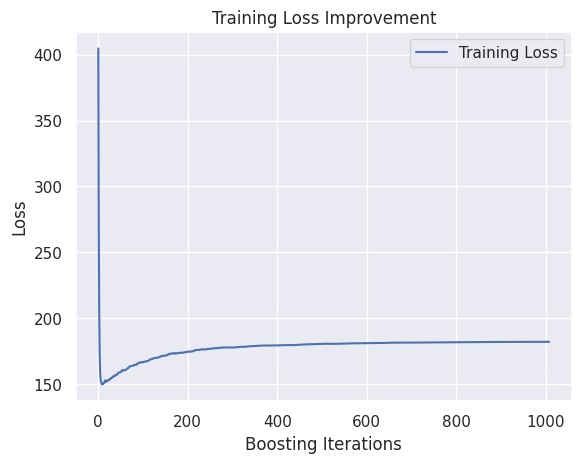

XGB Mean squared error for bin$(360, 900): 22439.10
529     495
2948    525
7207    585
3194    660
1856    510
       ... 
5655    810
1523    585
5413    780
4246    405
4267    810
Name: trip_time, Length: 271, dtype: int64
[594.00226 615.55316 595.44183 689.09894 616.24133 640.34424 613.5414
 557.6951  655.91174 562.03735 531.2107  559.9038  598.02295 621.7405
 642.67017 558.6237  639.2673  607.3956  673.2064  505.59076 594.21185
 556.6201  608.9473  622.71625 605.7483  614.8584  655.91174 644.10144
 595.4669  621.7405  548.86884 553.9791  619.8862  621.31506 673.0314
 644.6263  631.1654  483.65    527.44366 570.5949  580.7806  632.98267
 587.65674 526.1854  632.259   587.65674 586.23083 651.2348  611.91705
 609.5011  605.9964  528.92413 606.6073  609.49677 598.85095 506.20178
 604.4486  604.0089  623.6252  633.13635 639.53754 642.9784  617.1631
 657.07385 608.2426  609.7855  611.82324 594.77783 494.91626 607.95105
 594.96545 591.5962  643.5339  594.0865  611.9435  600.343   618.11

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


{'validation_0': OrderedDict([('rmse', [1109.0383732640153, 1098.0664322047567, 1087.2065752903866, 1076.4575749236312, 1065.8183850646697, 1055.287941872562, 1044.8651673891975, 1034.5490493278298, 1024.3384890339125, 1014.2325089061645, 1004.2300381270937, 994.33003658593, 984.531591642371, 974.83373395994, 965.2354032674776, 955.7356520648934, 946.3335075744383, 937.0280121957587, 927.8182836320162, 918.7033483647002, 909.6822894464628, 900.7541851734901, 891.9181900691132, 883.1733450122441, 874.5188037323127, 865.9536814073967, 857.477107888208, 849.0882374812819, 840.786143671228, 832.5700759231468, 824.4392432255689, 816.3927325435964, 808.4297465827713, 800.5494985549788, 792.7511585270186, 785.0339766384282, 777.3971432375819, 769.8399240887226, 762.3616072465142, 754.9612293679969, 747.6382462869636, 740.3918355376524, 733.2212713609465, 726.1258312077136, 719.1047360199202, 712.1573939140106, 705.2829703841951, 698.4808583258917, 691.7503462999529, 685.0907200471828, 678.501

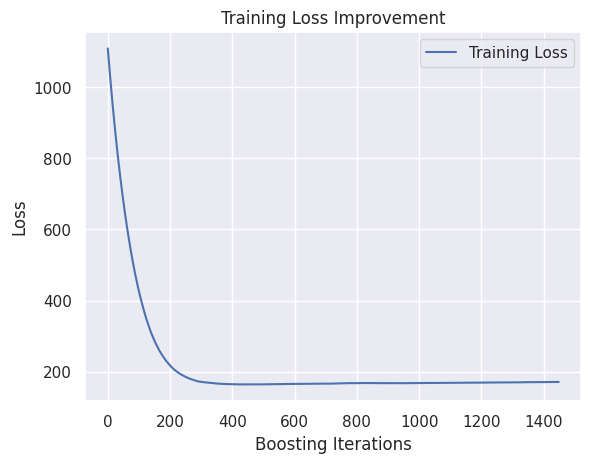

XGB Mean squared error for bin$(900, 1500): 26993.35
2942     945
8296     990
8752     960
8149    1080
2857     960
        ... 
1314    1005
9103    1155
7128    1050
501     1080
5241    1080
Name: trip_time, Length: 86, dtype: int64
[1053.7839  1059.4553  1038.9727  1210.3419  1083.6886  1041.3445
 1106.093   1083.699   1096.6136  1054.9711  1131.1674  1030.7115
 1062.4755  1132.0765  1066.9714  1094.2898  1100.1674  1142.2721
 1085.6053  1130.6483  1123.3164  1063.2426  1082.2396  1084.0486
 1109.944   1066.6936  1067.7386   993.6929  1120.52    1188.3345
 1149.7997  1122.8639  1072.7238  1127.0991  1070.3756  1107.4515
 1091.5969  1084.1654  1102.4905  1184.6982  1113.0212  1109.6484
 1113.1715  1137.8096  1135.5557  1114.14    1120.3862  1107.9725
 1081.882   1125.8412  1083.3665  1156.7527  1064.9711  1193.6587
 1060.5544  1109.2856  1104.2659  1061.9883  1122.9781  1113.143
 1097.9043  1100.9584  1106.0792  1197.895   1072.08     998.0141
 1119.144   1067.4567  1123.327   103

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


{'validation_0': OrderedDict([('rmse', [1701.3465198980573, 1684.548347366553, 1667.9181865196738, 1651.4544754898284, 1635.1556089206358, 1619.0197829836136, 1603.0456469339374, 1587.2313824828634, 1571.5755078656186, 1556.076346505481, 1540.7325555372379, 1525.5422743304202, 1510.5043223017628, 1495.6169809968574, 1480.8787931495272, 1466.288439721714, 1451.8441654562073, 1437.544795288668, 1423.38873818785, 1409.374663568099, 1395.501095553962, 1381.7668316047673, 1368.1701634496515, 1354.7099852849574, 1341.3848398060634, 1328.1934231243465, 1315.134458612795, 1302.206548221429, 1289.40845485887, 1276.738931057138, 1264.1965561938175, 1251.7803360076339, 1239.4887167078825, 1227.3207020861462, 1215.275071743019, 1203.35039097577, 1191.5456550535205, 1179.8597089028456, 1168.291281843175, 1156.8392698010584, 1145.502396498853, 1134.2797528353874, 1123.1700415821695, 1112.1722637391968, 1101.285114693808, 1090.507732840357, 1079.8390059847595, 1069.2776452784879, 1058.8228768851684, 

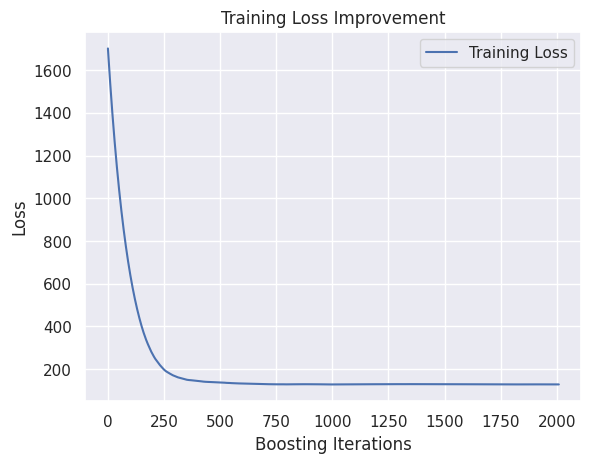

XGB Mean squared error for bin$(1500, 2000): 16340.69
689     1560
192     1695
5235    1695
7817    1800
7340    1905
6286    1770
7282    1605
3932    1605
212     1680
3227    1770
1127    1965
7815    1560
3741    1680
Name: trip_time, dtype: int64
[1653.3867 1819.9403 1626.4232 1704.7362 1789.8954 1679.6935 1628.3815
 1634.0258 1623.7255 1727.1565 1635.2476 1669.391  1519.3113]


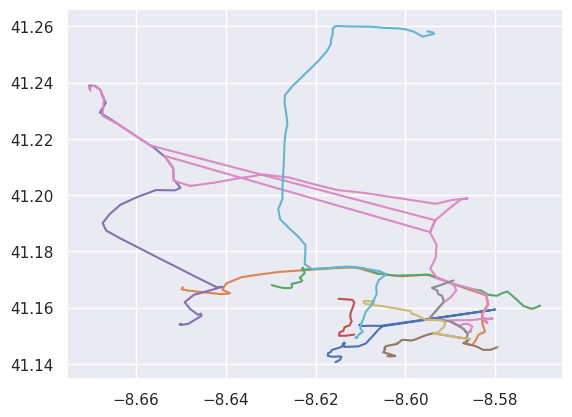

In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

bins = [(0, 360, 0.4, 200), (360, 900, 0.4, 200), (900, 1500,0.01, 200), (1500, 2000, 0.01, 200)]

dictOne, dictTwo, dictThree, dictFour, dictFive, dictSix = {}, {}, {}, {}, {}, {}
index = 0

# for question 2 on milestone
differences = []

# import pandas as pd
import seaborn as sns
# import matplotlib.pyplot as plt


# head_df = df[(df.get('Latitude') != -1) & (df.get('Longitude') != -1)]
# print(head_df.shape[0])
# # Create a heatmap using seaborn
# sns.set(style="darkgrid")
# plt.figure(figsize=(10, 8))
# sns.kdeplot(x=head_df['Longitude'], y=head_df['Latitude'], shade=True, cmap='viridis')

# # Set the labels and title of the plot
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.title('Distribution of Trip Positions')

# # Display the heatmap
# plt.show()

for lower, upper, lr, offset in bins:
    #generate dataframe
    currDf = df[(df.get("trip_time") > lower) & (df.get("trip_time") <= upper)]
    # print("currDf", len(currDf))
    #generate training data
    curr_X = currDf.drop(["trip_time", "TIMESTAMP", "ORIGIN_STAND", "MISSING_DATA", "Area", "CALL_TYPE", "POLYLINE"], axis=1)
    curr_y = currDf["trip_time"]
    curr_X_train, curr_X_val, curr_y_train, curr_y_val = train_test_split(curr_X, curr_y, test_size=0.05, random_state=42)

    print("currDf shape:", currDf.shape[0])

    columns_to_scale = ["TAXI_ID", "YR", "MON", "DAY", "HR", "WK", "Latitude", "Longitude", "A", "B", "C", "Area_Nums"]

    scaler = StandardScaler()
    scaler.fit(curr_X_train[columns_to_scale])

    curr_X_train_scaled = curr_X_train.copy()
    curr_X_val_scaled = curr_X_val.copy()
    curr_X_train_scaled[columns_to_scale] = scaler.transform(curr_X_train[columns_to_scale])
    curr_X_val_scaled[columns_to_scale] = scaler.transform(curr_X_val[columns_to_scale])
    

    eval_set = [(curr_X_val_scaled, curr_y_val)]
    model = XGBRegressor(n_estimators=5000, learning_rate=lr, max_depth=7, random_state=42, reg_alpha=1, reg_lambda=1)

    # Fit the model on the training data
    model.fit(curr_X_train_scaled, curr_y_train, eval_set=eval_set, eval_metric="rmse", early_stopping_rounds=1000, verbose=False)

    # Get the evaluation results
    eval_results = model.evals_result()
    print(eval_results)

    # Extract the training loss values
    plt.plot(eval_results['validation_0']['rmse'], label='Training Loss')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Loss')
    plt.title('Training Loss Improvement')
    plt.legend()
    plt.show()

    # Make predictions on the validation set
    y_pred = model.predict(curr_X_val_scaled)

    # Calculate the mean squared error
    mse = mean_squared_error(curr_y_val, y_pred)
    print(f"XGB Mean squared error for bin${(lower,upper)}: {mse:.2f}")
    num_predictions = len(curr_y_val)
    for i in range(num_predictions):
        differences.append(y_pred[i] - curr_y_val.values[i])

    print(curr_y_val)
    print(y_pred)
    
    # testing predictions
    modelOut = pd.read_csv('680_score.csv')
    newdf =  modelOut[(modelOut.get("TRAVEL_TIME") > lower - offset) & (modelOut.get("TRAVEL_TIME") <= upper + offset)]
    
    test_df = pd.read_csv('test_public.csv')
    mergedUnderDf = test_df.merge(newdf, left_on='TRIP_ID', right_on='TRIP_ID')
    test_df = mergedUnderDf
    
    test_df[["YR", "MON", "DAY", "HR", "WK"]] = test_df[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
    
    test_df['ORIGIN_STAND'].fillna(15.0, inplace=True)
    test_df[["Latitude", "Longitude", "Area"]] = test_df[["ORIGIN_STAND"]].apply(parse_stand, axis=1, result_type="expand")
    test_df['TAXI_ID'] = test_df['TAXI_ID'] - 20000000 
    # perform one-hot encoding
    one_hot = pd.get_dummies(test_df['CALL_TYPE'])
    # concatenate the one-hot encoded dataframe with the original dataframe
    test_df['A'] = 0
    test_df['B'] = 0
    test_df['C'] = 0
    
    if('A' in one_hot.columns):
        test_df['A'] = one_hot['A']
    if('B' in one_hot.columns):
        test_df['B'] = one_hot['B']
    if('C' in one_hot.columns):
        test_df['C'] = one_hot['C']

    le = LabelEncoder()
    le.fit(test_df['Area'])
    test_df['Area_Nums'] = le.transform(test_df['Area'])

    tripidSeriesUnder = test_df.get('TRIP_ID')

    # Define a list of columns to be scaled
    columns_to_scale = ["TAXI_ID", "YR", "MON", "DAY", "HR", "WK", "A", "B", "C", "Latitude", "Longitude", "Area_Nums"]

    

    X_test = test_df.drop(["CALL_TYPE",'ORIGIN_CALL', 'DAY_TYPE', 'TRIP_ID', "TIMESTAMP", "ORIGIN_STAND", "MISSING_DATA", "Area", "TRAVEL_TIME"], axis=1)
    X_test_scaled = X_test.copy()
    # Create a scaler object and fit it on the training data
    scaler.fit(test_df[columns_to_scale])
    X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])


    y_pred_under = model.predict(X_test_scaled)


    for i, val in enumerate(tripidSeriesUnder.values):
        if(index == 0):
            dictOne[val] = y_pred_under[i]
        elif(index == 1):
            dictTwo[val] = y_pred_under[i]
        elif(index == 2):
            dictThree[val] = y_pred_under[i]
        elif(index == 3):
            dictFour[val] = y_pred_under[i]
        elif(index == 4):
            dictFive[val] = y_pred_under[i]
        else:
            dictSix[val] = y_pred_under[i]
    
    index += 1

top_loss_indices = np.argsort(differences)[::-1][:10]
top_samples = df['POLYLINE'].iloc[top_loss_indices]
fig, ax = plt.subplots()
for i in range(len(top_samples)):
    polyline = top_samples.values[i]
    coords = polyline.split("],[")
    coords[0] = coords[0][2:]
    coords[-1] = coords[-1][:-2]
    longitudes = []
    latitudes = []
    for coord in coords:
        coordinate = coord.split(",")
        longitudes.append(float(coordinate[0]))
        latitudes.append(float(coordinate[1]))
    ax.plot(longitudes, latitudes)

In [ ]:
import re
import pandas as pd

# Combine the dictionaries and average values for duplicate keys
combined_dict = {}
all_dicts = [dictOne, dictTwo, dictThree, dictFour, dictFive, dictSix]

for dictionary in all_dicts:
    for key, value in dictionary.items():
        if key in combined_dict:
            combined_dict[key].append(value)
        else:
            combined_dict[key] = [value]

for key, values in combined_dict.items():
    average_value = sum(values) / len(values)
    combined_dict[key] = average_value

# Extract the numeric part from the keys and sort based on numeric value
sorted_keys = sorted(combined_dict.keys(), key=lambda x: int(x[1:]))

# Create a pandas Series with the sorted keys and values
s = pd.Series([combined_dict[k] for k in sorted_keys], index=sorted_keys)

print(s)

# Creating the DataFrame
data = {
    'TRIP_ID': s.index,
    'TRAVEL_TIME': s.values
}
submit_df = pd.DataFrame(data)

# Saving the DataFrame as a CSV file
submit_df.to_csv('myPreds.csv', index=False)

T1       544.413757
T2       410.961060
T3       841.438629
T4       631.818176
T5      1823.116943
           ...     
T323     433.374008
T324     818.840363
T325     414.889252
T326     389.428207
T327     428.621696
Length: 320, dtype: float64
